# Setup

In [1]:
# standard libraries
import importlib, re, os, multiprocessing

# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import sklearn.svm
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import sklearn.decomposition
import sklearn.neural_network

# scripts
from scripts import files, train
importlib.reload(files)
importlib.reload(train)

paths = files.getPaths()
os.chdir(paths['dirProject'])
print('Current working directory: ' + os.getcwd())

Current working directory: /home/users/bentyeh/projects/disprot


## Read data and data pre-processing

In [5]:
reprocess = True

Datasets (training and test) from [Perovic et al.](https://doi.org/10.1038/s41598-018-28815-x)

In [ ]:
xlsx = pd.ExcelFile(paths['IDPpi_datasets'])
num_datasets = 5
allData_list = []
for i in range(num_datasets):
    # many sheet names have trailing whitespace
    train_sheet_name = 'Table S' + str(i+7) + '-DisorderTrainSet' + str(i+1)
    train_sheet_name = np.where([name.startswith(train_sheet_name) for name in xlsx.sheet_names])[0][0]
    test_sheet_name = 'Table S' + str(i+12) + '-DisorderTestSet' + str(i+1)
    test_sheet_name = np.where([name.startswith(test_sheet_name) for name in xlsx.sheet_names])[0][0]
    
    train_set = pd.read_excel(xlsx, sheet_name=train_sheet_name)
    train_set = train_set.iloc[:,0].str.split(expand=True)
    train_set.columns = ['label', 'p1_uniprotName', 'p2_uniprotName']
    
    test_set = pd.read_excel(xlsx, sheet_name=test_sheet_name)
    test_set = test_set.iloc[:,0].str.split(expand=True)
    test_set.columns = ['label', 'p1_uniprotName', 'p2_uniprotName']
    allData_list.append(train_set)
    allData_list.append(test_set)
    
    if reprocess:
        train_set.to_csv(paths['IDPpi_set'].format('train', i+1), **files.save_kwargs)
        test_set.to_csv(paths['IDPpi_set'].format('test', i+1), **files.save_kwargs)

allData = pd.concat(allData_list, ignore_index=True).drop_duplicates().reset_index(drop=True)
allData.to_csv(paths['IDPpi_dataAll'], **files.save_kwargs)

del xlsx, allData_list

In [3]:
allData = pd.read_table(paths['IDPpi_dataAll'])
allData

,label,p1_uniprotName,p2_uniprotName
0,1,MAX_HUMAN,MYC_HUMAN
1,1,SHC1_HUMAN,GRB2_HUMAN
2,1,GRB2_HUMAN,SHC1_HUMAN
3,1,DAXX_HUMAN,P53_HUMAN
4,1,P53_HUMAN,DAXX_HUMAN
5,1,CANB1_HUMAN,PP2BA_HUMAN
6,1,PP2BA_HUMAN,CANB1_HUMAN
7,1,SAE1_HUMAN,SAE2_HUMAN
8,1,SAE2_HUMAN,SAE1_HUMAN
9,1,TF65_HUMAN,IKBA_HUMAN


In [6]:
if reprocess:
    allData_aug = pd.concat(
        [allData, allData.rename({'p1_uniprotName': 'p2_uniprotName', 'p2_uniprotName': 'p1_uniprotName'},
                                 axis='columns')],
        ignore_index=True, sort=False) \
        .drop_duplicates() \
        .reset_index(drop=True)
    allData_aug.to_csv(paths['IDPpi_dataAll_aug'])
else:
    allData_aug = pd.read_table(paths['IDPpi_dataAll_aug'])
allData_aug

,label,p1_uniprotName,p2_uniprotName
0,1,MAX_HUMAN,MYC_HUMAN
1,1,SHC1_HUMAN,GRB2_HUMAN
2,1,GRB2_HUMAN,SHC1_HUMAN
3,1,DAXX_HUMAN,P53_HUMAN
4,1,P53_HUMAN,DAXX_HUMAN
5,1,CANB1_HUMAN,PP2BA_HUMAN
6,1,PP2BA_HUMAN,CANB1_HUMAN
7,1,SAE1_HUMAN,SAE2_HUMAN
8,1,SAE2_HUMAN,SAE1_HUMAN
9,1,TF65_HUMAN,IKBA_HUMAN


In [7]:
allData_trim = allData_aug[allData_aug['p1_uniprotName'] > allData_aug['p2_uniprotName']]
allData_trim.to_csv(paths['IDPpi_dataAll_trim'], **files.save_kwargs)

## Featurization

Run featurize.Rmd

# Training

Split data into training, validation, and test sets

In [3]:
X_raw = pd.read_table(paths['IDPpi_featuresPCA_unc'])
Y = np.loadtxt(paths['IDPpi_labelsAll_aug'], dtype=np.int32)

In [4]:
X = X_raw.values
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [5]:
np.random.seed(1)
perm = np.random.permutation(X.shape[0])
trainIdx = perm[:int(np.floor(0.6*len(perm)))]
valIdx = perm[int(np.floor(0.6*len(perm))):int(np.floor(0.8*len(perm)))]
testIdx = perm[int(np.floor(0.8*len(perm))):]

In [6]:
X_train = X[trainIdx,:]
Y_train = Y[trainIdx]
X_val = X[valIdx,:]
Y_val = Y[valIdx]
X_test = X[testIdx,:]
Y_test = Y[testIdx]

In [7]:
np.savetxt(paths['ml_train_features'], X[trainIdx,:], delimiter='\t')
np.savetxt(paths['ml_train_labels'], Y[trainIdx])
np.savetxt(paths['ml_val_features'], X[valIdx,:], delimiter='\t')
np.savetxt(paths['ml_val_labels'], Y[valIdx])
np.savetxt(paths['ml_test_features'], X[testIdx,:], delimiter='\t')
np.savetxt(paths['ml_test_labels'], Y[testIdx])

## Data Visualization

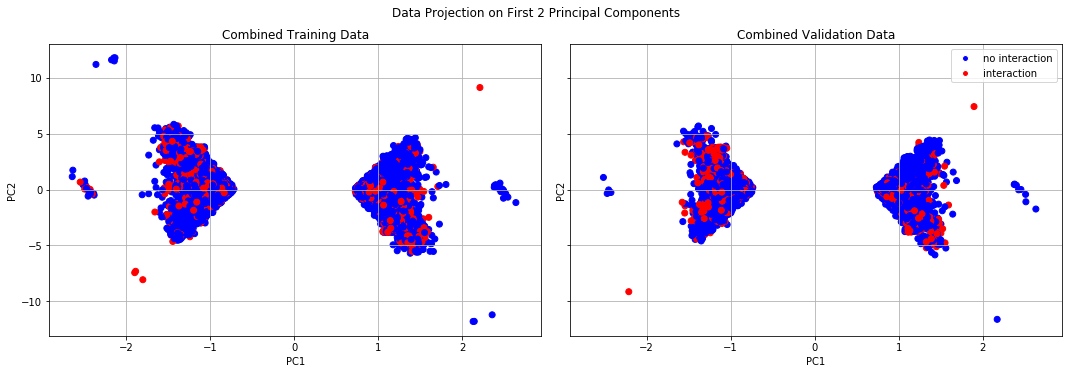

In [8]:
colors = np.array(['blue', 'red'])
labels = ['no interaction', 'interaction']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharex=True, sharey=True)
axs[0].scatter(X_train[:,0], X_train[:,1], color=colors[Y_train])
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].set_title('Combined Training Data')
axs[1].scatter(X_test[:,0], X_test[:,1], color=colors[Y_test])
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].set_title('Combined Validation Data')
legend_elements = [Line2D([0],[0], marker='o', color='w', label='no interaction', markerfacecolor='b'),
                   Line2D([0],[0], marker='o', color='w', label='interaction', markerfacecolor='r')]
axs[1].legend(handles=legend_elements, loc='best')
axs[0].grid(True)
axs[1].grid(True)

fig.suptitle('Data Projection on First 2 Principal Components', y=1.03)
fig.tight_layout()
fig.savefig(paths['pca'], dpi=300)

Choose models

In [9]:
models = [sklearn.linear_model.LogisticRegression(C=0.1),
          sklearn.linear_model.LogisticRegression(C=1),
          sklearn.linear_model.LogisticRegression(C=10),
          sklearn.svm.LinearSVC(C=0.1, max_iter=2000),
          sklearn.svm.LinearSVC(C=1, max_iter=2000),
          sklearn.svm.LinearSVC(C=10, max_iter=2000),
          sklearn.ensemble.RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_leaf=5),
          sklearn.ensemble.RandomForestClassifier(n_estimators=10, max_depth=10,   min_samples_leaf=5),
          sklearn.ensemble.RandomForestClassifier(n_estimators=10, max_depth=50,   min_samples_leaf=5),
          sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_leaf=5),
          sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=10,  min_samples_leaf=5),
          sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=50,  min_samples_leaf=5),
          sklearn.ensemble.RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=5),
          sklearn.ensemble.RandomForestClassifier(n_estimators=200, max_depth=10,   min_samples_leaf=5),
          sklearn.ensemble.RandomForestClassifier(n_estimators=200, max_depth=50,  min_samples_leaf=5),
          sklearn.svm.SVC(kernel='rbf', C=0.1, cache_size=2000),
          sklearn.svm.SVC(kernel='rbf', C=1, cache_size=2000),
          sklearn.svm.SVC(kernel='rbf', C=10, cache_size=2000),
          sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100,), alpha=1e-4, max_iter=100),
          sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100,), alpha=1e-3, max_iter=100),
          sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100,), alpha=1e-2, max_iter=100),
          sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100,100), alpha=1e-4, max_iter=25),
          #sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100,100), alpha=1e-3, max_iter=100),
          #sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100,100), alpha=1e-2, max_iter=100),
         ]
models_names = ['Logistic Regression (C=0.1)',
                'Logistic Regression (C=1)',
                'Logistic Regression (C=10)',
                'Linear SVM (C=0.1)',
                'Linear SVM (C=1)',
                'Linear SVM (C=10)',
                'Random Forest Classifier (n=10, max_depth=None)',
                'Random Forest Classifier (n=10, max_depth=10)',
                'Random Forest Classifier (n=10, max_depth=50)',
                'Random Forest Classifier (n=100, max_depth=None)',
                'Random Forest Classifier (n=100, max_depth=10)',
                'Random Forest Classifier (n=100, max_depth=50)',
                'Random Forest Classifier (n=200, max_depth=None)',
                'Random Forest Classifier (n=200, max_depth=10)',
                'Random Forest Classifier (n=200, max_depth=50)',
                'RBF SVM (C=0.1)',
                'RBF SVM (C=1)',
                'RBF SVM (C=10)',
                 'Neural Network (layers=1, alpha=1e-4)',
                 'Neural Network (layers=1, alpha=1e-3)',
                 'Neural Network (layers=1, alpha=1e-2)',
                 'Neural Network (layers=2, alpha=1e-4)',
#                 'Neural Network (layers=2, alpha=1e-3)',
#                 'Neural Network (layers=2, alpha=1e-2)',
               ]
nModels = len(models)
nThreads = len(os.sched_getaffinity(0))

In [ ]:
fittedModels = [None]*nModels
pool = multiprocessing.Pool(nThreads)

for i in range(nModels):
    fittedModels[i] = pool.apply_async(train.fit, (models[i], X_train, Y_train))

pool.close()
pool.join()

/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


done fittingLogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
done fittingLogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
done fittingLogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/users/bentyeh/miniconda3/envs/rpy3_tmp/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", Futu

done fittingRandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [ ]:
for i in range(nModels):
    fittedModels[i] = fittedModels[i].get()

### Plot results

In [ ]:
bestModel = None
bestAUROC = 0
results_train = {}
results_val = {}
for i in range(nModels):
    results_train[models_names[i]] = train.eval(fittedModels[i], X_train, Y_train)
    results_val[models_names[i]] = train.eval(fittedModels[i], X_val, Y_val)
    if results_val[models_names[i]]['roc_auc'] > bestAUROC:
        bestAUROC = results_val[models_names[i]]['roc_auc']
        bestModel = models_names[i]
    print(models_names[i],
          'train auroc: {:.5g}'.format(results_train[models_names[i]]['roc_auc']),
          'val auroc: {:.5g}'.format(results_val[models_names[i]]['roc_auc']),
          sep=', ')
print('Best model: {}'.format(bestModel))

Logistic Regression (C=0.1), train auroc: 0.7713, val auroc: 0.7605
Logistic Regression (C=1), train auroc: 0.77129, val auroc: 0.76049
Logistic Regression (C=10), train auroc: 0.77129, val auroc: 0.76048
Linear SVM (C=0.1), train auroc: 0.77323, val auroc: 0.7626
Linear SVM (C=1), train auroc: 0.76373, val auroc: 0.75415
Linear SVM (C=10), train auroc: 0.61724, val auroc: 0.61919
Random Forest Classifier (n=10, max_depth=None), train auroc: 0.99322, val auroc: 0.78106
Random Forest Classifier (n=10, max_depth=10), train auroc: 0.83055, val auroc: 0.76571
Random Forest Classifier (n=10, max_depth=50), train auroc: 0.99322, val auroc: 0.78118
Random Forest Classifier (n=100, max_depth=None), train auroc: 0.99949, val auroc: 0.82431
Random Forest Classifier (n=100, max_depth=10), train auroc: 0.85445, val auroc: 0.78465
Random Forest Classifier (n=100, max_depth=50), train auroc: 0.99949, val auroc: 0.82452
Random Forest Classifier (n=200, max_depth=5), train auroc: 0.85799, val auroc: 0

In [ ]:
bestIndex = models_names.index(bestModel)
results_test = train.eval(fittedModels[bestIndex], X_test, Y_test)
print('Test results: {:.5g}'.format(results_test['roc_auc']))

In [ ]:
figs_comb, ax = plt.subplots(1,3, figsize=(15,6))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('Training dataset')
ax[0].grid(True)
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('Validation dataset')
ax[1].grid(True)
ax[2].set_xlabel('False positive rate')
ax[2].set_ylabel('True positive rate')
ax[2].set_title('Test dataset')
ax[2].grid(True)

for i in [0, 3, 11, 15, 18]:
    ax[0].plot(results_train[models_names[i]]['fpr'], results_train[models_names[i]]['tpr'])
    ax[1].plot(results_val[models_names[i]]['fpr'], results_val[models_names[i]]['tpr'],
               label=models_names[i] + '(AUROC = {:0.2f})'.format(results_val[models_names[i]]['roc_auc']))
ax[2].grid(True)
ax[2].plot(results_test['fpr'], results_test['tpr'], 'g-')
figs_comb.legend(loc='lower center', bbox_to_anchor=[0.5, 0.00])
figs_comb.suptitle('Best ROC Curves for Each Model Type on Validation Dataset', y=1.03)
figs_comb.tight_layout()
figs_comb.subplots_adjust(bottom=0.3)
figs_comb.savefig(paths['mlPlots'].format('best_roc_per_model_type', dpi=300))
plt.show()